In [1]:
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import Markdown, display
from networks import *
from model import model, configurator_classificators, posterior_configurator, constrain_parameters, constrained_parameter_names
from cmdstanpy import CmdStanModel
from bayesflow.trainers import Trainer
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork, SequenceNetwork
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from logging import getLogger

import bayesflow.diagnostics as diagnostics

stan_logger = getLogger("cmdstanpy")
stan_logger.disabled = True

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [2]:
stan_model = CmdStanModel(stan_file="stan-model.stan")

In [3]:
classification_net = Sequential([
    LSTM(16, return_sequences=True),
    Classifier(n_classes=2, n_units=[16, 8, 4])
])


classification = Trainer(
    amortizer=AmortizedSmoothing(
        forward_net=classification_net,
        backward_net=Backward(classification_net)
        ),
    configurator=configurator_classificators,
    checkpoint_path="checkpoints/smoothing"
)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from checkpoints/smoothing/history_100.pkl.
INFO:root:Networks loaded from checkpoints/smoothing/ckpt-100


In [4]:
posterior = Trainer(
    amortizer=AmortizedPosterior(
    inference_net=InvertibleNetwork(num_params=4, num_coupling_layers=10, coupling_design="spline"),
    summary_net=SequenceNetwork(summary_dim=12, num_conv_layers=4, bidirectional=True),
    summary_loss_fun = "MMD"),
    generative_model=model,
    configurator=posterior_configurator,
    checkpoint_path="checkpoints/posterior"
)

INFO:root:Loaded loss history from checkpoints/posterior/history_100.pkl.
INFO:root:Networks loaded from checkpoints/posterior/ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


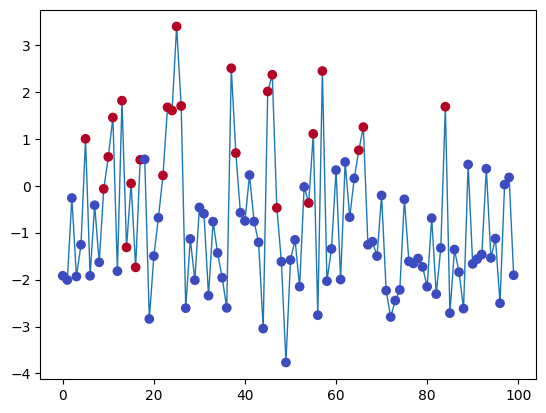

In [5]:
true_params_unconstrained = np.array([[2.0, 0.5, -1.5, 0.8]])
true_params = constrain_parameters(true_params_unconstrained)

df = model.simulator(true_params_unconstrained)
df['prior_draws'] = true_params_unconstrained

# df['sim_data'][0,:,0] = np.array([-1.5 + 3 * np.exp(- 0.002 * (t-50)**2) for t in range(100)])
# df['sim_data'][0,:,1] = np.float32(df['sim_data'][0,:,0] < 0.0)
# df['sim_data'][0,:,0] = df['sim_data'][0,:,0] + np.random.normal(loc=0, scale=0.01, size=100)

df_classification = configurator_classificators(df)
df_posterior = posterior_configurator(df)

observables = df_classification['summary_conditions'][0,...,0]
latents = df_classification['latents'][0,...,1]

stan_df = {
    "n_obs": 100,
    "y": observables,
    "alpha": [[2, 2], [2, 2]]
}


plt.plot(observables, linewidth=1, zorder=-1)
f=plt.scatter(range(len(observables)), observables, c=latents, cmap='coolwarm')

In [6]:
stan_fit = stan_model.sample(stan_df, show_progress=False)
print(stan_fit.diagnose())

Processing csv files: /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpu9c251me/stan-modeli8wygkiy/stan-model-20240705114945_1.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpu9c251me/stan-modeli8wygkiy/stan-model-20240705114945_2.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpu9c251me/stan-modeli8wygkiy/stan-model-20240705114945_3.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpu9c251me/stan-modeli8wygkiy/stan-model-20240705114945_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [7]:
stan_posterior = stan_fit.draws_pd(vars = ["transition_matrix", "mu"])
stan_posterior = np.array(stan_posterior)
stan_posterior = stan_posterior[:, (0, 3, 4, 5)]

In [8]:
bf_posterior_unconstrained = posterior.amortizer.sample(df_posterior, n_samples=4000)
bf_posterior = constrain_parameters(bf_posterior_unconstrained)

df_classification["parameters"] = tf.expand_dims(bf_posterior_unconstrained, axis=0)

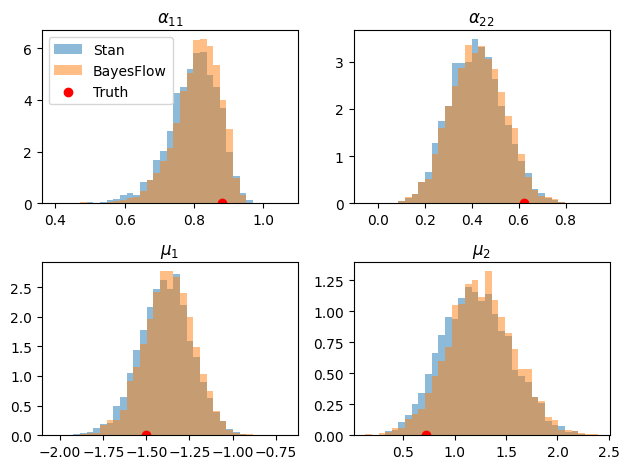

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2)
axs = axs.flatten()

bins = [
    np.linspace(np.min(stan_posterior[:,i])-0.1, np.max(stan_posterior[:,i])+0.1, 36) for i in range(4)
]
for i, par in enumerate(constrained_parameter_names):
    axs[i].hist(stan_posterior[:,i], bins=bins[i], alpha = 0.5, density=True, label="Stan")
    axs[i].hist(bf_posterior[:,i], bins=bins[i], alpha = 0.5, density=True, label="BayesFlow")
    axs[i].scatter(true_params[0,i], 0, color="red", label="Truth")
    axs[i].set_title(par)

axs[0].legend()
fig.tight_layout()

In [10]:
stan_forward   = stan_fit.stan_variables()["filtering"]
stan_backward  = stan_fit.stan_variables()["backward_filtering"]
stan_smoothing = stan_fit.stan_variables()["smoothing"]

In [11]:
bf_forward, bf_backward, bf_smoothing = classification.amortizer.sample(df_classification, shift=True)

In [12]:
df_losses = df_classification
df_losses['latents'] = np.tile(df_classification['latents'], (1, 4000, 1, 1))

In [13]:
losses = {
    "stan": {
        "forward":   classification.amortizer.loss(df_losses['latents'][0], stan_forward),
        "backward":  classification.amortizer.loss(df_losses['latents'][0], stan_backward),
        "smoothing": classification.amortizer.loss(df_losses['latents'][0], stan_smoothing),
    },
    "bf": {
        "forward":   classification.amortizer.loss(df_losses['latents'], bf_forward),
        "backward":  classification.amortizer.loss(df_losses['latents'], bf_backward),
        "smoothing": classification.amortizer.loss(df_losses['latents'], bf_smoothing),
    }
}

In [14]:
stan_forward   = stan_forward[...,1]
stan_backward  = stan_backward[...,1]
stan_smoothing = stan_smoothing[...,1]

bf_forward=bf_forward[0,...,1]
bf_backward=bf_backward[0,...,1]
bf_smoothing=bf_smoothing[0,...,1]

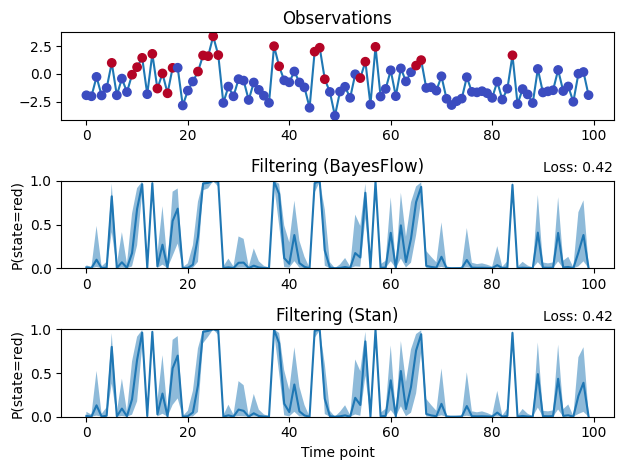

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.plot(range(len(observables)), observables, zorder=-1)
ax1.scatter(range(len(observables)), observables, c=latents, cmap='coolwarm')
ax1.set_title("Observations")

ax2.plot(range(len(observables)), np.median(bf_forward, axis=0))
ax2.fill_between(
    range(len(observables)),
    np.quantile(bf_forward, q=0.01, axis=0),
    np.quantile(bf_forward, q=0.99, axis=0),
    alpha=0.5
)
ax2.text(len(observables)-10, 1.1, "Loss: {0:.2f}".format(losses["bf"]["forward"]))
ax2.set_title("Filtering (BayesFlow)")
ax2.set_ylabel("P(state=red)")
ax2.set_ylim([0, 1])


ax3.plot(range(len(observables)), np.median(stan_forward, axis=0))
ax3.fill_between(
    range(len(observables)),
    np.quantile(stan_forward, q=0.01, axis=0),
    np.quantile(stan_forward, q=0.99, axis=0),
    alpha=0.5
)
ax3.text(len(observables)-10, 1.1, "Loss: {0:.2f}".format(losses["stan"]["forward"]))
ax3.set_title("Filtering (Stan)")
ax3.set_ylabel("P(state=red)")
ax3.set_xlabel("Time point")
ax3.set_ylim([0, 1])

fig.tight_layout()

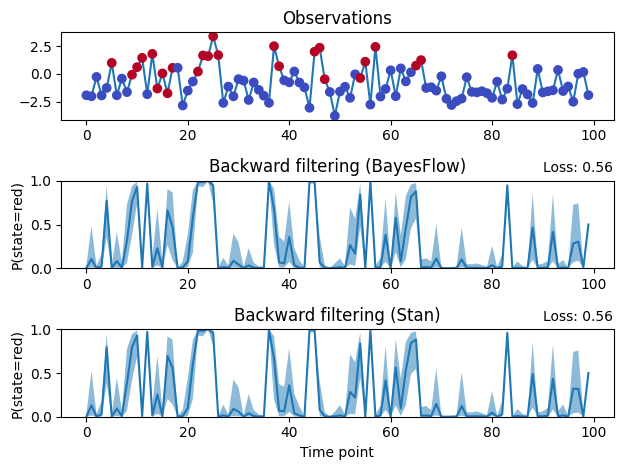

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.plot(range(len(observables)), observables, zorder=-1)
ax1.scatter(range(len(observables)), observables, c=latents, cmap='coolwarm')
ax1.set_title("Observations")

ax2.plot(range(len(observables)), np.median(bf_backward, axis=0))
ax2.fill_between(
    range(len(observables)),
    np.quantile(bf_backward, q=0.01, axis=0),
    np.quantile(bf_backward, q=0.99, axis=0),
    alpha=0.5
)
ax2.text(len(observables)-10, 1.1, "Loss: {0:.2f}".format(losses["bf"]["backward"]))
ax2.set_title("Backward filtering (BayesFlow)")
ax2.set_ylabel("P(state=red)")
ax2.set_ylim([0, 1])

ax3.plot(range(len(observables)), np.median(stan_backward, axis=0))
ax3.fill_between(
    range(len(observables)),
    np.quantile(stan_backward, q=0.01, axis=0),
    np.quantile(stan_backward, q=0.99, axis=0),
    alpha=0.5
)
ax3.text(len(observables)-10, 1.1, "Loss: {0:.2f}".format(losses["stan"]["backward"]))
ax3.set_title("Backward filtering (Stan)")
ax3.set_ylabel("P(state=red)")
ax3.set_xlabel("Time point")
ax3.set_ylim([0, 1])

fig.tight_layout()

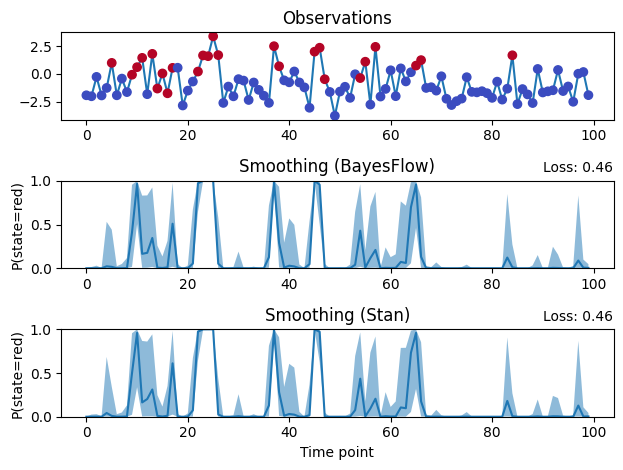

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.plot(range(len(observables)), observables, zorder=-1)
ax1.scatter(range(len(observables)), observables, c=latents, cmap='coolwarm')
ax1.set_title("Observations")

ax2.plot(range(len(observables)), np.median(bf_smoothing, axis=0))
ax2.fill_between(
    range(len(observables)),
    np.quantile(bf_smoothing, q=0.01, axis=0),
    np.quantile(bf_smoothing, q=0.99, axis=0),
    alpha=0.5
)
ax2.text(len(observables)-10, 1.1, "Loss: {0:.2f}".format(losses["bf"]["smoothing"]))
ax2.set_title("Smoothing (BayesFlow)")
ax2.set_ylabel("P(state=red)")
ax2.set_ylim([0, 1])

ax3.plot(range(len(observables)), np.median(stan_smoothing, axis=0))
ax3.fill_between(
    range(len(observables)),
    np.quantile(stan_smoothing, q=0.01, axis=0),
    np.quantile(stan_smoothing, q=0.99, axis=0),
    alpha=0.5
)
ax3.text(len(observables)-10, 1.1, "Loss: {0:.2f}".format(losses["stan"]["smoothing"]))
ax3.set_title("Smoothing (Stan)")
ax3.set_ylabel("P(state=red)")
ax3.set_xlabel("Time point")
ax3.set_ylim([0, 1])

fig.tight_layout()